# ABHISHAKE DAS

## GRIP- Sparks Foundation
### Data Science and Business Analytics
**TASK 7: Stock Market Prediction using Numerical and Textual Analysis**

● Objective: Create a hybrid model for stock price/performance prediction using numerical analysis of historical stock prices, and sentimental analysis of news headlines

● Stock to analyze and predict - SENSEX (S&P BSE SENSEX)

● Download historical stock prices from finance.yahoo.com

#### I have used Auto-ARIMA model to make stock market prices predictions using the historical stock prices data. In the sentiment analysis model, I have made use of different machine learning algorithms-Random Forest Regressor, LightGBM, Adaboost and Xgboost- to make the predictions. 

# Time Series Analysis

In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('vader_lexicon')
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
import xgboost 
import lightgbm

In [2]:
df_prices = pd.read_csv('BSESN.csv')

In [3]:
df_prices.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-03-16,24537.609375,24706.849609,24354.550781,24682.480469,24682.480469,11000.0
1,2016-03-17,24852.179688,24948.300781,24576.519531,24677.369141,24677.369141,14600.0
2,2016-03-18,24729.410156,24986.939453,24681.640625,24952.740234,24952.740234,14100.0
3,2016-03-21,25007.560547,25327.449219,24988.269531,25285.369141,25285.369141,12400.0
4,2016-03-22,25331.009766,25381.330078,25083.699219,25330.490234,25330.490234,12000.0


In [4]:
df_prices.size

8631

In [5]:
df_prices.shape

(1233, 7)

In [6]:
#Converting Date column to datetime datatype
df_prices['Date'] = pd.to_datetime(df_prices['Date'])
df_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1233 entries, 0 to 1232
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1233 non-null   datetime64[ns]
 1   Open       1228 non-null   float64       
 2   High       1228 non-null   float64       
 3   Low        1228 non-null   float64       
 4   Close      1228 non-null   float64       
 5   Adj Close  1228 non-null   float64       
 6   Volume     1228 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 67.6 KB


In [7]:
df_prices.dropna(inplace = True)

Text(0, 0.5, 'Close')

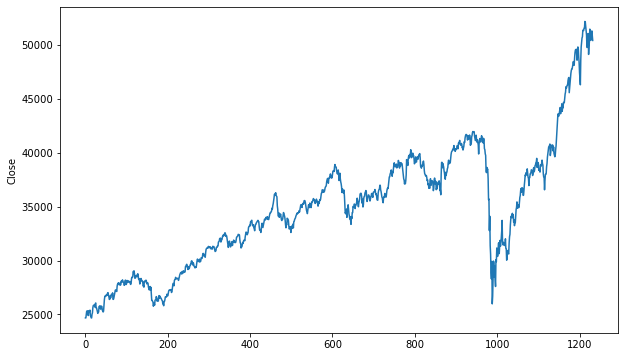

In [8]:
plt.figure(figsize=(10, 6))
df_prices['Close'].plot()
plt.ylabel('Close')

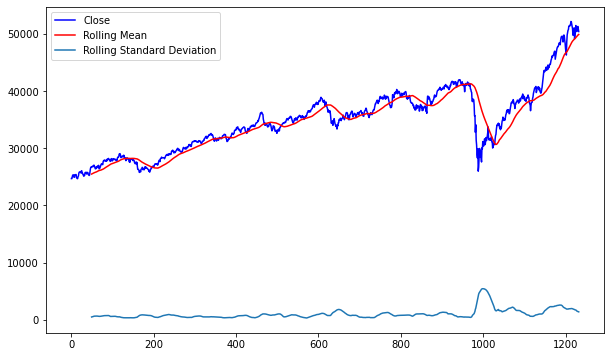

In [9]:
#Plotting moving average
close = df_prices['Close']
ma = close.rolling(window = 50).mean()
std = close.rolling(window = 50).std()

plt.figure(figsize=(10, 6))
df_prices['Close'].plot(color = 'b', label = 'Close')
ma.plot(color = 'r', label = 'Rolling Mean')
std.plot(label = 'Rolling Standard Deviation')
plt.legend()

Text(0.5, 1.0, 'Returns')

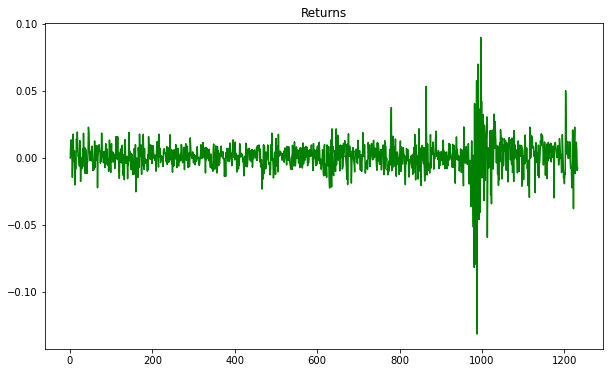

In [10]:
#Plotting returns
returns = close / close.shift(1) - 1

plt.figure(figsize = (10,6))
returns.plot(label='Return', color = 'g')
plt.title("Returns")

In [12]:
train = df_prices[:1000]
test = df_prices[1000:]

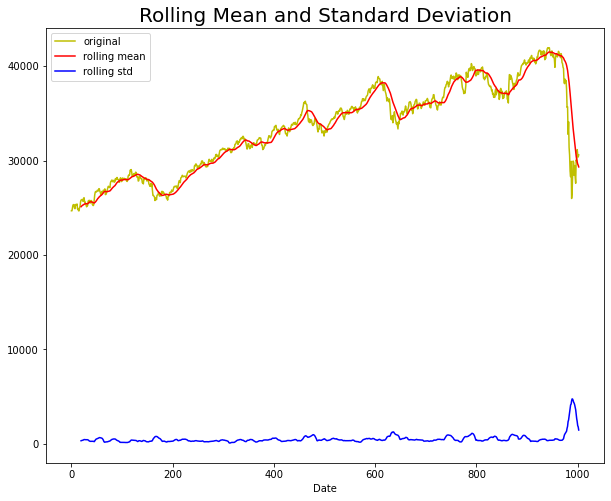

Results of dickey fuller test
ADF Test Statistic : -2.1369202087970867
p-value : 0.22993019012630556
#Lags Used : 15
Number of Observations Used : 984
Weak evidence against null hypothesis, time series is non-stationary 


In [13]:
#Stationarity test
def test_stationarity(timeseries):

 #Determing rolling statistics
 rolmean = timeseries.rolling(20).mean()
 rolstd = timeseries.rolling(20).std()

 #Plot rolling statistics:
 plt.figure(figsize = (10,8))
 plt.plot(timeseries, color = 'y', label = 'original')
 plt.plot(rolmean, color = 'r', label = 'rolling mean')
 plt.plot(rolstd, color = 'b', label = 'rolling std')
 plt.xlabel('Date')
 plt.legend()
 plt.title('Rolling Mean and Standard Deviation',  fontsize = 20)
 plt.show(block = False)
 
 print('Results of dickey fuller test')
 result = adfuller(timeseries, autolag = 'AIC')
 labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
 for value,label in zip(result, labels):
   print(label+' : '+str(value) )
 if result[1] <= 0.05:
   print("Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
 else:
   print("Weak evidence against null hypothesis, time series is non-stationary ")
test_stationarity(train['Close'])

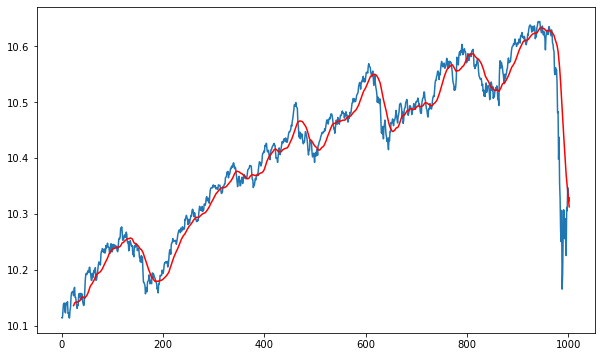

In [14]:
train_log = np.log(train['Close']) 
test_log = np.log(test['Close'])

mav = train_log.rolling(24).mean() 
plt.figure(figsize = (10,6))
plt.plot(train_log) 
plt.plot(mav, color = 'red')

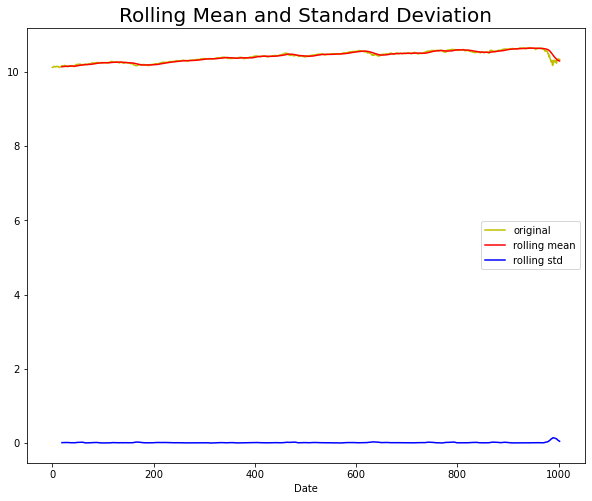

Results of dickey fuller test
ADF Test Statistic : -2.2242329154977534
p-value : 0.19756814768979614
#Lags Used : 15
Number of Observations Used : 984
Weak evidence against null hypothesis, time series is non-stationary 


In [15]:
train_log.dropna(inplace = True)
test_log.dropna(inplace = True)

test_stationarity(train_log)

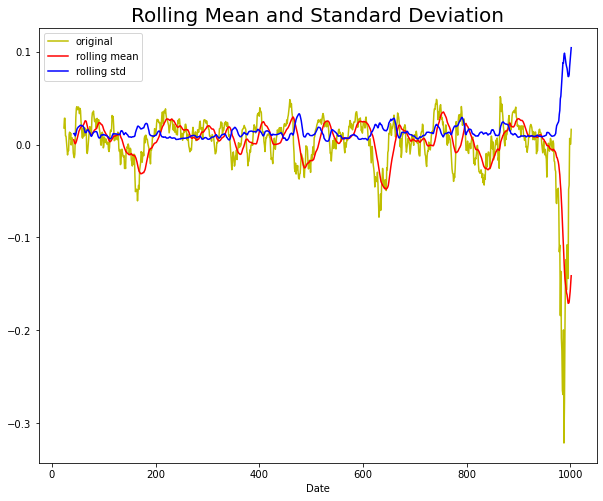

Results of dickey fuller test
ADF Test Statistic : -5.649164366259228
p-value : 9.952084191947006e-07
#Lags Used : 15
Number of Observations Used : 961
Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


In [16]:
train_log_diff = train_log - mav
train_log_diff.dropna(inplace = True)

test_stationarity(train_log_diff)

In [17]:
#Using auto arima to make predictions using log data
from pmdarima import auto_arima
model = auto_arima(train_log, trace = True, error_action = 'ignore', suppress_warnings = True)
model.fit(train_log)
predictions = model.predict(n_periods = len(test))
predictions = pd.DataFrame(predictions,index = test_log.index,columns=['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-6092.799, Time=0.88 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-6104.039, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-6108.980, Time=0.28 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-6108.179, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-6105.681, Time=0.20 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-6109.815, Time=0.23 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-6109.305, Time=0.97 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-6111.189, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-6108.183, Time=0.28 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-6107.257, Time=0.40 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-6104.956, Time=0.35 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-6105.043, Time=0.77 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-6112.924, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-6109.772, Time=0.26 sec
 ARIMA(2,1,0)(0,0,0

Text(0, 0.5, 'Actual Stock Price')

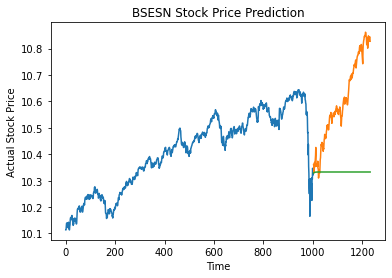

In [18]:
plt.plot(train_log, label='Train')
plt.plot(test_log, label='Test')
plt.plot(predictions, label='Prediction')
plt.title('BSESN Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')

In [19]:
#Calculating error
rms = np.sqrt(mean_squared_error(test_log,predictions))
print("RMSE : ", rms)

RMSE :  0.3115516184512361


# Textual Analysis

In [20]:
cols = ['Date','Category','News']
df_news = pd.read_csv('india-news-headlines.csv', names = cols)
df_news

,Date,Category,News
0,publish_date,headline_category,headline_text
1,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
2,20010102,unknown,Fissures in Hurriyat over Pak visit
3,20010102,unknown,America's unwanted heading for India?
4,20010102,unknown,For bigwigs; it is destination Goa
...,...,...,...
3424063,20201231,city.jodhpur,Covid-19: Despite dip in cases; Rajasthan amon...
3424064,20201231,city.udaipur,Covid-19: Despite dip in cases; Rajasthan amon...
3424065,20201231,city.ajmer,Covid-19: Despite dip in cases; Rajasthan amon...
3424066,20201231,removed,Govt extends deadline for use of FASTag till F...


In [21]:
df_news.drop(0, inplace=True)
df_news.drop('Category', axis = 1, inplace=True)
df_news.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3424067 entries, 1 to 3424067
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   Date    object
 1   News    object
dtypes: object(2)
memory usage: 78.4+ MB


In [22]:
#Converting data type of Date column 
df_news['Date'] = pd.to_datetime(df_news['Date'],format= '%Y%m%d')
df_news

,Date,News
1,2001-01-02,Status quo will not be disturbed at Ayodhya; s...
2,2001-01-02,Fissures in Hurriyat over Pak visit
3,2001-01-02,America's unwanted heading for India?
4,2001-01-02,For bigwigs; it is destination Goa
5,2001-01-02,Extra buses to clear tourist traffic
...,...,...
3424063,2020-12-31,Covid-19: Despite dip in cases; Rajasthan amon...
3424064,2020-12-31,Covid-19: Despite dip in cases; Rajasthan amon...
3424065,2020-12-31,Covid-19: Despite dip in cases; Rajasthan amon...
3424066,2020-12-31,Govt extends deadline for use of FASTag till F...


In [23]:
#Grouping the headlines for each day
df_news['News'] = df_news.groupby(['Date']).transform(lambda x : ' '.join(x)) 
df_news = df_news.drop_duplicates() 
df_news.reset_index(inplace = True, drop = True)
df_news

,Date,News
0,2001-01-02,Status quo will not be disturbed at Ayodhya; s...
1,2001-01-03,Powerless north India gropes in the dark Think...
2,2001-01-04,The string that pulled Stephen Hawking to Indi...
3,2001-01-05,Light combat craft takes India into club class...
4,2001-01-06,Light combat craft takes India into club class...
...,...,...
7257,2020-12-27,#BigInterview! Dhritiman Chatterjee: Nobody da...
7258,2020-12-28,Horoscope Today; 28 December 2020: Check astro...
7259,2020-12-29,Man recovers charred remains of 'thief' from h...
7260,2020-12-30,Numerology Readings 30 December 2020: Predicti...


In [24]:
df_news['News']

0       Status quo will not be disturbed at Ayodhya; s...
1       Powerless north India gropes in the dark Think...
2       The string that pulled Stephen Hawking to Indi...
3       Light combat craft takes India into club class...
4       Light combat craft takes India into club class...
                              ...                        
7257    #BigInterview! Dhritiman Chatterjee: Nobody da...
7258    Horoscope Today; 28 December 2020: Check astro...
7259    Man recovers charred remains of 'thief' from h...
7260    Numerology Readings 30 December 2020: Predicti...
7261    Horoscope Today; 31 December 2020: Check astro...
Name: News, Length: 7262, dtype: object

In [32]:
#Cleaning headlines
c = []
ps=PorterStemmer()
for i in range(0,len(df_news['News'])):
    news = re.sub('[^a-zA-Z]',' ',df_news['News'][i])
    news = news.lower()
    news = news.split()
    news = [ps.stem(word) for word in news if not word in set(stopwords.words('english'))]
    news=' '.join(news)
    c.append(news)

In [33]:
df_news['News'] = pd.Series(c)
df_news

,Date,News,Subjectivity,Polarity
0,2001-01-02,statu quo disturb ayodhya say vajpaye fissur h...,0.286859,0.143590
1,2001-01-03,powerless north india grope dark think laxman ...,0.392857,0.089286
2,2001-01-04,string pull stephen hawk india vajpaye give bi...,0.445360,0.093039
3,2001-01-05,light combat craft take india club class hawk ...,0.480553,0.264024
4,2001-01-06,light combat craft take india club class hawk ...,0.439394,0.248485
...,...,...,...,...
7257,2020-12-27,biginterview dhritiman chatterje nobodi dare m...,0.392082,0.042978
7258,2020-12-28,horoscop today decemb check astrolog predict a...,0.409973,0.071405
7259,2020-12-29,man recov char remain thief burnt shop dump be...,0.415684,0.060775
7260,2020-12-30,numerolog read decemb predict lucki colour luc...,0.436863,0.046930


In [34]:
#Functions to get the subjectivity and polarity
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
    return  TextBlob(text).sentiment.polarity

In [35]:
#Adding subjectivity and polarity columns
df_news['Subjectivity'] = df_news['News'].apply(getSubjectivity)
df_news['Polarity'] = df_news['News'].apply(getPolarity)
df_news

,Date,News,Subjectivity,Polarity
0,2001-01-02,statu quo disturb ayodhya say vajpaye fissur h...,0.298148,0.099074
1,2001-01-03,powerless north india grope dark think laxman ...,0.429167,0.025000
2,2001-01-04,string pull stephen hawk india vajpaye give bi...,0.475140,0.032481
3,2001-01-05,light combat craft take india club class hawk ...,0.458412,0.296404
4,2001-01-06,light combat craft take india club class hawk ...,0.425758,0.389394
...,...,...,...,...
7257,2020-12-27,biginterview dhritiman chatterje nobodi dare m...,0.366994,0.058187
7258,2020-12-28,horoscop today decemb check astrolog predict a...,0.395275,0.085493
7259,2020-12-29,man recov char remain thief burnt shop dump be...,0.399135,0.068856
7260,2020-12-30,numerolog read decemb predict lucki colour luc...,0.389012,0.040116


<AxesSubplot:>

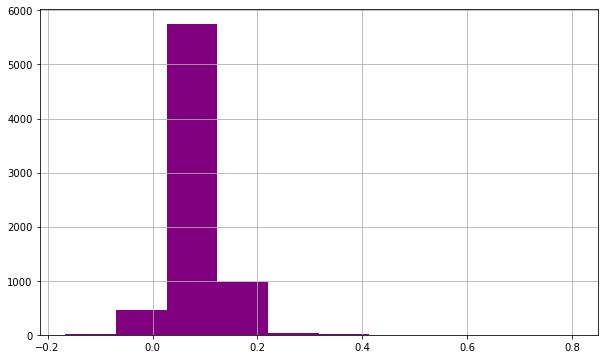

In [36]:
plt.figure(figsize = (10,6))
df_news['Polarity'].hist(color = 'purple')

<AxesSubplot:>

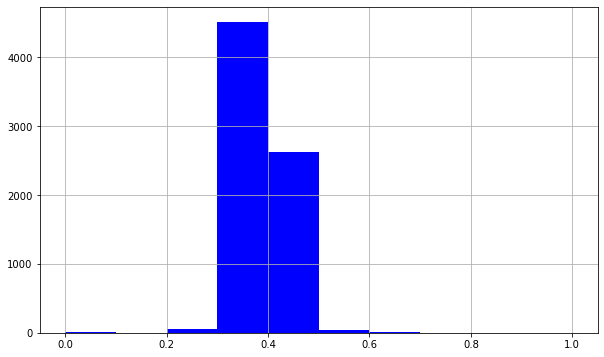

In [37]:
plt.figure(figsize = (10,6))
df_news['Subjectivity'].hist(color = 'blue')

In [38]:
#Adding sentiment score to df_news
sia = SentimentIntensityAnalyzer()

df_news['Compound'] = [sia.polarity_scores(v)['compound'] for v in df_news['News']]
df_news['Negative'] = [sia.polarity_scores(v)['neg'] for v in df_news['News']]
df_news['Neutral'] = [sia.polarity_scores(v)['neu'] for v in df_news['News']]
df_news['Positive'] = [sia.polarity_scores(v)['pos'] for v in df_news['News']]
df_news

,Date,News,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2001-01-02,statu quo disturb ayodhya say vajpaye fissur h...,0.298148,0.099074,-0.8555,0.125,0.773,0.102
1,2001-01-03,powerless north india grope dark think laxman ...,0.429167,0.025000,-0.5994,0.132,0.755,0.113
2,2001-01-04,string pull stephen hawk india vajpaye give bi...,0.475140,0.032481,0.9169,0.099,0.791,0.110
3,2001-01-05,light combat craft take india club class hawk ...,0.458412,0.296404,-0.3612,0.171,0.659,0.170
4,2001-01-06,light combat craft take india club class hawk ...,0.425758,0.389394,-0.7579,0.207,0.649,0.144
...,...,...,...,...,...,...,...,...
7257,2020-12-27,biginterview dhritiman chatterje nobodi dare m...,0.366994,0.058187,-0.9998,0.145,0.786,0.068
7258,2020-12-28,horoscop today decemb check astrolog predict a...,0.395275,0.085493,-0.9996,0.120,0.807,0.074
7259,2020-12-29,man recov char remain thief burnt shop dump be...,0.399135,0.068856,-0.9998,0.145,0.782,0.073
7260,2020-12-30,numerolog read decemb predict lucki colour luc...,0.389012,0.040116,-0.9999,0.149,0.782,0.069


In [39]:
df_merge = pd.merge(df_prices, df_news, how='inner', on='Date')
df_merge

,Date,Open,High,Low,Close,Adj Close,Volume,News,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2016-03-16,24537.609375,24706.849609,24354.550781,24682.480469,24682.480469,11000.0,inspir ranveer singh quirki fashion sens readi...,0.366961,0.084938,-0.9997,0.137,0.766,0.096
1,2016-03-17,24852.179688,24948.300781,24576.519531,24677.369141,24677.369141,14600.0,celebr believ alien could one woman cruel anot...,0.387073,0.036451,-0.9999,0.156,0.759,0.085
2,2016-03-18,24729.410156,24986.939453,24681.640625,24952.740234,24952.740234,14100.0,app pet parent need take break troubl relation...,0.364355,0.059570,-0.9999,0.149,0.768,0.083
3,2016-03-21,25007.560547,25327.449219,24988.269531,25285.369141,25285.369141,12400.0,stuck wrong job smartphon zombi cute celebr ki...,0.386351,0.090106,-0.9994,0.139,0.757,0.104
4,2016-03-22,25331.009766,25381.330078,25083.699219,25330.490234,25330.490234,12000.0,thing women must learn men deal workplac break...,0.389363,0.099977,-0.9998,0.147,0.764,0.089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1174,2020-12-24,46743.488281,47053.398438,46539.019531,46973.539063,46973.539063,13700.0,set mood sex cold winter two hous blow gujarat...,0.386303,0.065157,-0.9995,0.116,0.809,0.075
1175,2020-12-28,47153.589844,47406.718750,47148.238281,47353.750000,47353.750000,9600.0,horoscop today decemb check astrolog predict a...,0.395275,0.085493,-0.9996,0.120,0.807,0.074
1176,2020-12-29,47466.621094,47714.550781,47361.898438,47613.078125,47613.078125,12800.0,man recov char remain thief burnt shop dump be...,0.399135,0.068856,-0.9998,0.145,0.782,0.073
1177,2020-12-30,47789.031250,47807.851563,47358.359375,47746.218750,47746.218750,15600.0,numerolog read decemb predict lucki colour luc...,0.389012,0.040116,-0.9999,0.149,0.782,0.069


In [40]:
df = df_merge[['Close','Subjectivity', 'Polarity', 'Compound', 'Negative', 'Neutral' ,'Positive']]
df

,Close,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,24682.480469,0.366961,0.084938,-0.9997,0.137,0.766,0.096
1,24677.369141,0.387073,0.036451,-0.9999,0.156,0.759,0.085
2,24952.740234,0.364355,0.059570,-0.9999,0.149,0.768,0.083
3,25285.369141,0.386351,0.090106,-0.9994,0.139,0.757,0.104
4,25330.490234,0.389363,0.099977,-0.9998,0.147,0.764,0.089
...,...,...,...,...,...,...,...
1174,46973.539063,0.386303,0.065157,-0.9995,0.116,0.809,0.075
1175,47353.750000,0.395275,0.085493,-0.9996,0.120,0.807,0.074
1176,47613.078125,0.399135,0.068856,-0.9998,0.145,0.782,0.073
1177,47746.218750,0.389012,0.040116,-0.9999,0.149,0.782,0.069


In [41]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
new_df = pd.DataFrame(sc.fit_transform(df))
new_df.columns = df.columns
new_df.index = df.index
new_df.head()

,Close,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,0.000374,0.228877,0.309061,0.000153,0.495146,0.313559,0.671233
1,0.000153,0.318190,0.156562,0.000051,0.679612,0.254237,0.520548
2,0.012085,0.217306,0.229273,0.000051,0.611650,0.330508,0.493151
3,0.026499,0.314982,0.325314,0.000306,0.514563,0.237288,0.780822
4,0.028454,0.328357,0.356361,0.000102,0.592233,0.296610,0.575342


In [42]:
X = new_df.drop('Close', axis=1)
y =new_df['Close']

In [43]:
X.head()

,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,0.228877,0.309061,0.000153,0.495146,0.313559,0.671233
1,0.318190,0.156562,0.000051,0.679612,0.254237,0.520548
2,0.217306,0.229273,0.000051,0.611650,0.330508,0.493151
3,0.314982,0.325314,0.000306,0.514563,0.237288,0.780822
4,0.328357,0.356361,0.000102,0.592233,0.296610,0.575342


In [44]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)
x_train.shape

(943, 6)

In [45]:
x_train[:10]

,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
413,0.184156,0.267277,0.000051,0.631068,0.305085,0.506849
412,0.235535,0.261369,0.000051,0.640777,0.347458,0.410959
1041,0.268243,0.257100,0.000255,0.378641,0.567797,0.438356
494,0.344074,0.259321,0.000051,0.582524,0.330508,0.534247
481,0.141585,0.373405,0.000051,0.553398,0.398305,0.452055
1178,0.406640,0.367748,0.000255,0.300971,0.686441,0.356164
866,0.405125,0.445055,0.000153,0.456311,0.508475,0.424658
308,0.271624,0.232811,0.000204,0.330097,0.559322,0.520548
97,0.296544,0.244668,0.000153,0.572816,0.228814,0.712329
247,0.197037,0.230672,0.000255,0.359223,0.508475,0.561644


In [46]:
rf = RandomForestRegressor()
rf.fit(x_train, y_train)
prediction=rf.predict(x_test)

In [47]:
print(prediction[:10])
print(y_test[:10])
print(mean_squared_error(prediction,y_test))

[0.23462135 0.39529056 0.2585288  0.24608977 0.4871056  0.41443178
 0.4999716  0.19217748 0.41339435 0.35936165]
161     0.070666
932     0.693437
416     0.385125
356     0.306662
678     0.489182
267     0.202047
1114    0.576657
298     0.285969
690     0.469716
1009    0.391888
Name: Close, dtype: float64
0.03497204042925019


In [48]:
adb = AdaBoostRegressor()
adb.fit(x_train, y_train)
predictions = adb.predict(x_test)

In [49]:
print(mean_squared_error(predictions, y_test))

0.03473136815884288


In [50]:
from sklearn.tree import DecisionTreeRegressor
dec_tree = DecisionTreeRegressor()
dec_tree.fit(x_train, y_train)
predictions = dec_tree.predict(x_test)

In [51]:
print(predictions[:10])
print(y_test[:10])
print(mean_squared_error(predictions,y_test))

[0.14769805 0.57445288 0.15189002 0.32553674 0.69832292 0.47746443
 0.35355241 0.60877898 0.14426524 0.22280371]
161     0.070666
932     0.693437
416     0.385125
356     0.306662
678     0.489182
267     0.202047
1114    0.576657
298     0.285969
690     0.469716
1009    0.391888
Name: Close, dtype: float64
0.057248295673031524


In [52]:
lgb = lightgbm.LGBMRegressor()
lgb.fit(x_train, y_train)

LGBMRegressor()

In [53]:
predictions = lgb.predict(x_test)
print(mean_squared_error(predictions,y_test))

0.040642620210020006


In [54]:
xgb = xgboost.XGBRegressor()
xgb.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [55]:
predictions = xgb.predict(x_test)
print(mean_squared_error(predictions,y_test))

0.039929336481827865


### We observe that Xgboost perform the best for the sentiment analysis